In [7]:
import torch
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
def plot_mnist_digits(batches, ki_kf, reconstr, output=True):
    batches_to_plot = 1

    batch_size = len(batches[0])
    print('Batch size:', batch_size)

    num_digits = len(batches[0]) * batches_to_plot
    print('Num digits: ', num_digits)
    
    batches = batches[:batches_to_plot]
    # Create a grid of subplots with 20 rows and 20 columns
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    # fig, axes = plt.subplots(num_digits, 20, figsize=(20, 20))

    # Flatten the axes array to access the individual subplots easily
    axes = axes.flatten()

    # batches = [batches[i:i+784] for i in range(0, len(batch_correl_list), 784)]

    for batch_number, batch in enumerate(batches):
        for i, digit in enumerate(batch):
            # Convert Torch tensor to a NumPy array and reshape it to (28, 28)
            digit_np = digit.view(28, 28).detach().numpy()

            # Plot the digit using matplotlib
            axes[batch_number*batch_size + i].imshow(digit_np, cmap='gray')
            axes[batch_number*batch_size + i].axis('off')

    if output:
        plt.savefig(f'/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/nn_outputs/FashionMNIST/MOMENTS_reconstruction_flavour=fashion_kikf={ki_kf}_bs=16_reconstr={reconstr}.pdf'.lower())
    # # Remove any remaining empty subplots
    # for i in range(num_digits, 39):
    #     axes[i].axis('off')

    plt.show()
    

In [10]:
import matplotlib.pyplot as plt

# Define a function to calculate cross-entropy divergence
def mse_divergence(input_batch, output_batch):
    # Flatten the input and output batches
    input_flat = input_batch.view(-1)
    output_flat = output_batch.view(-1)
    
    # Compute the cross-entropy loss
    loss = F.mse_loss(output_flat, input_flat, reduction='mean')
    
    return loss

In [11]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## 1, 2 and 3pt functions

In [12]:
orig_images_3pt = torch.load('/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0.001/batch_avg_approx_all_1pt_0.8-2pt_0.001-3pt_simpleout')
reconstructions_3pt = torch.load('/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0.001/mixed_reconstr_avg_approx_all_1pt_0.8-2pt_0.001-3pt_simpleout')

Batch size: 16
Num digits:  16


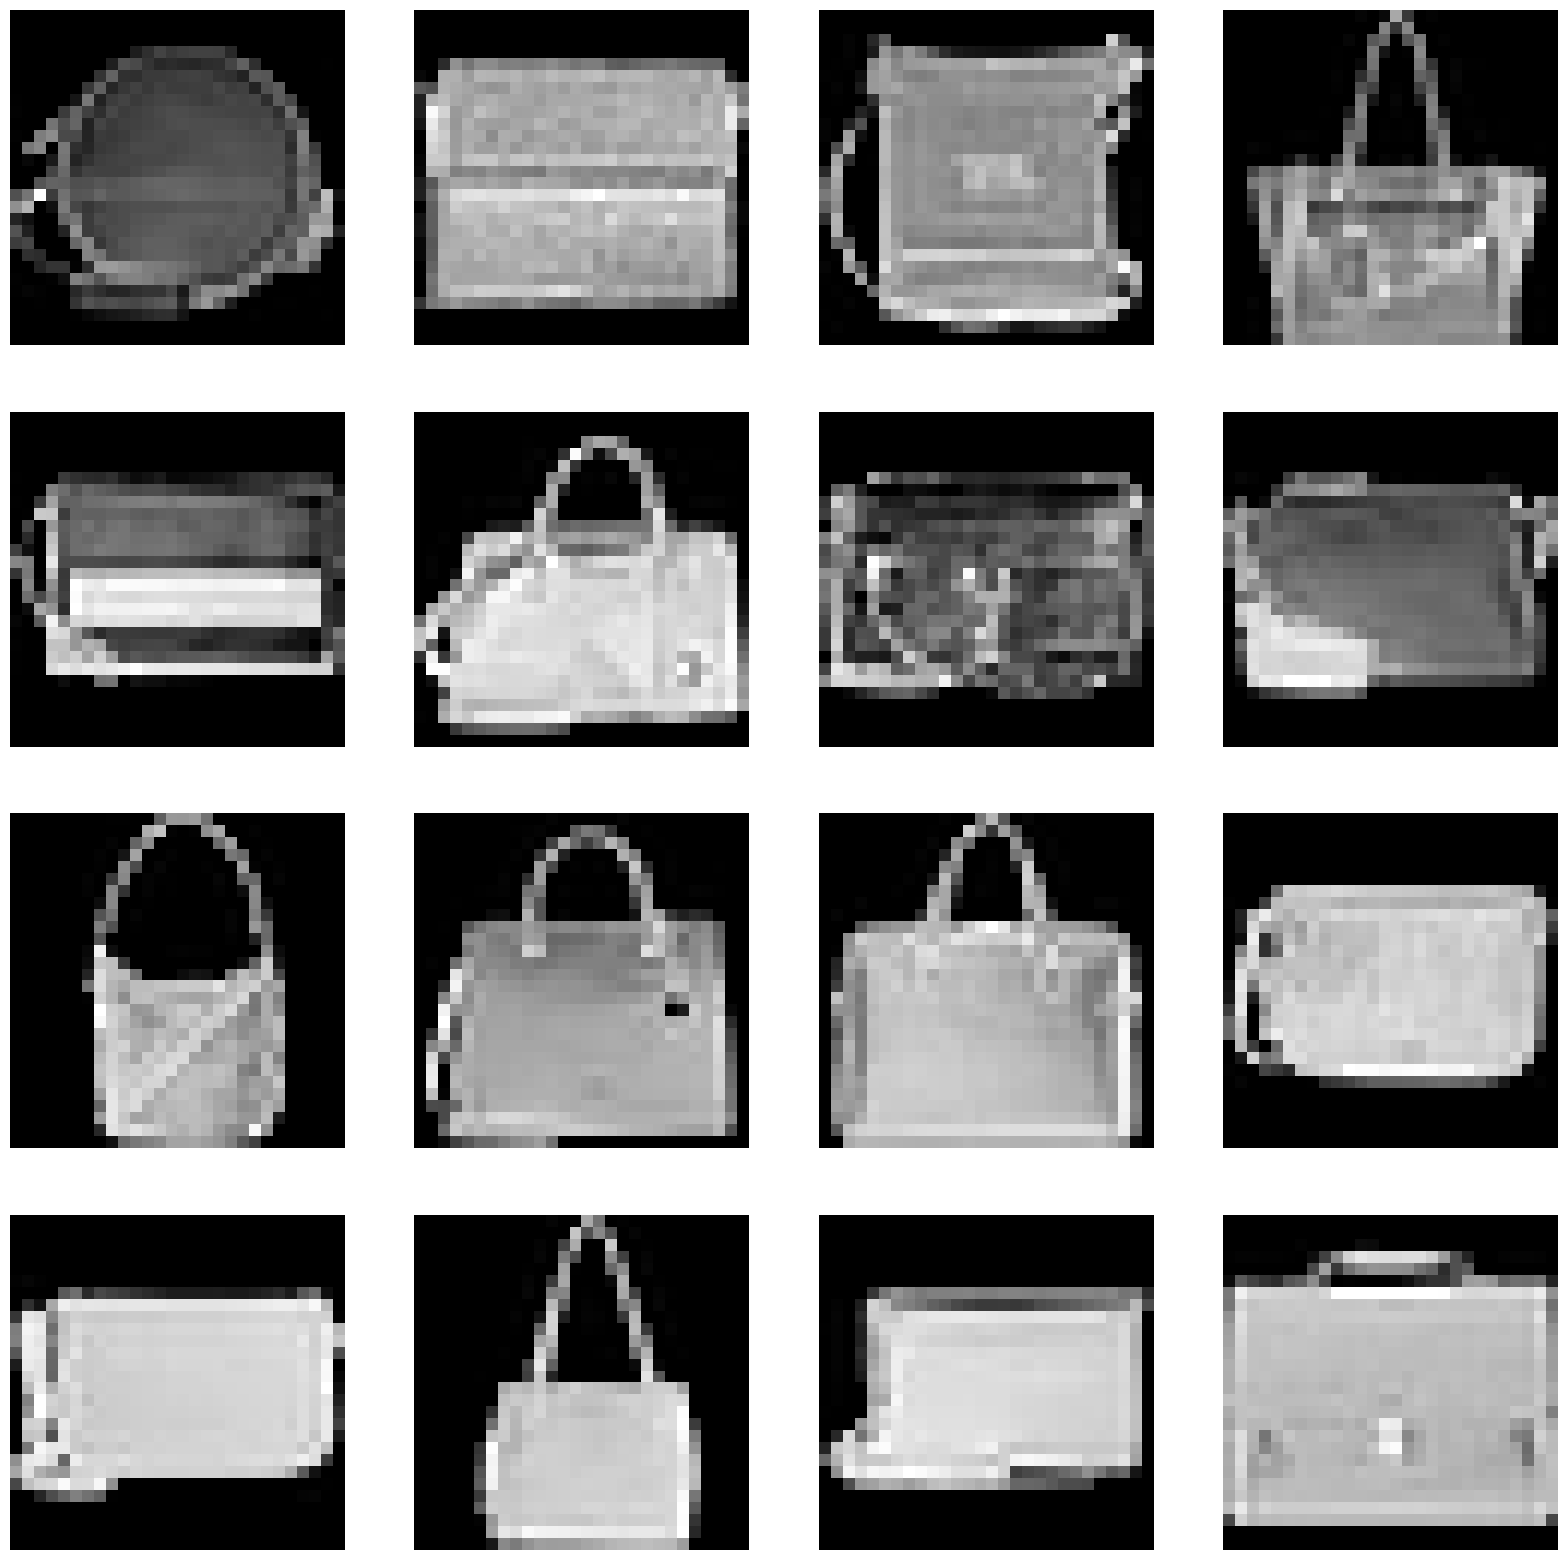

In [13]:
plot_mnist_digits(orig_images_3pt[500:], ki_kf='123', reconstr=False)

In [14]:
new_reconstructions_3pt = []
for batch in reconstructions_3pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_3pt.append(tidied_batch)
# reconstructions_2pt = new_reconstructions_2pt

Batch size: 16
Num digits:  16


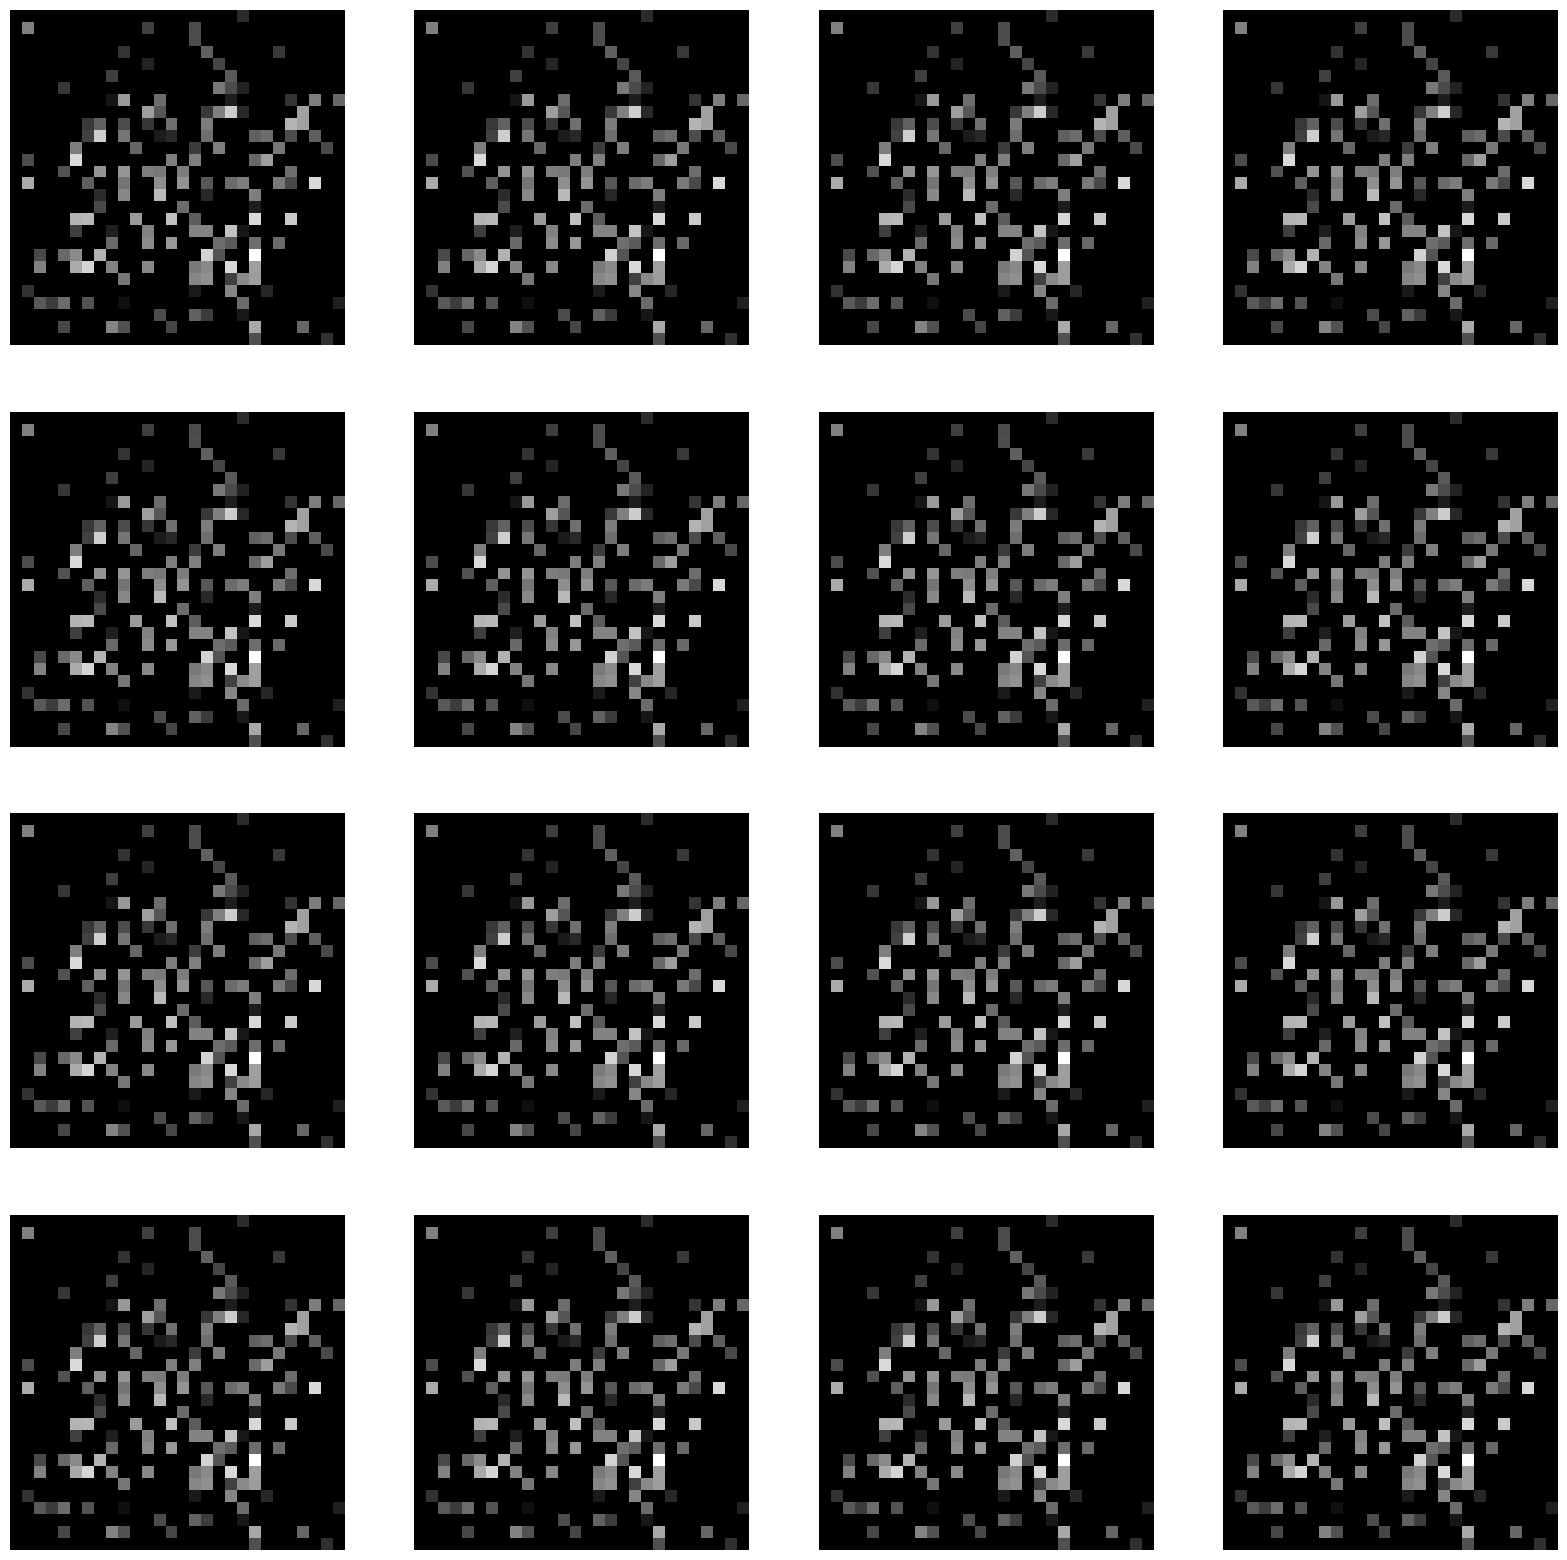

In [15]:
plot_mnist_digits(new_reconstructions_3pt[1500:], ki_kf='123', reconstr=True)

In [16]:
# Test Gaussian blur
def gaussian_blur_mnist_digit(flattened_tensor, kernel_size=5, sigma=1.0):
    # Reshape the flattened tensor back to its original shape (28x28)
    image = flattened_tensor.view(28, 28).unsqueeze(0).float()

    # Apply Gaussian blur
    blurred_image = F.gaussian_blur(image, kernel_size, sigma)

    # Remove the extra batch dimension
    blurred_image = blurred_image.squeeze(0)

    # Flatten the blurred image back to a tensor
    blurred_tensor = blurred_image.view(-1)

    return blurred_tensor

In [17]:
def plot_flattened_mnist_digit(flattened_digit):
    # Reshape the flattened tensor to its original shape (28x28)
    image = flattened_digit.view(28, 28)

    # Plot the digit
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

### Losses (Training) - 1,2&3pt

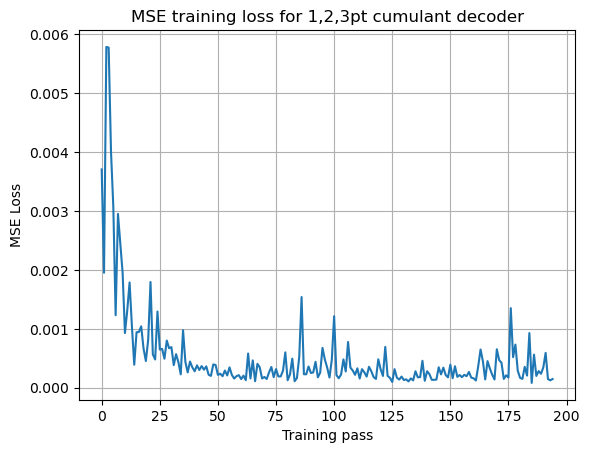

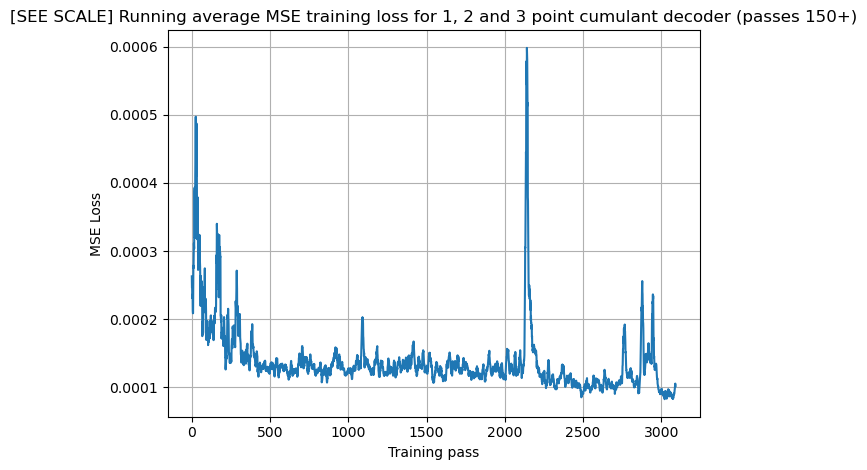

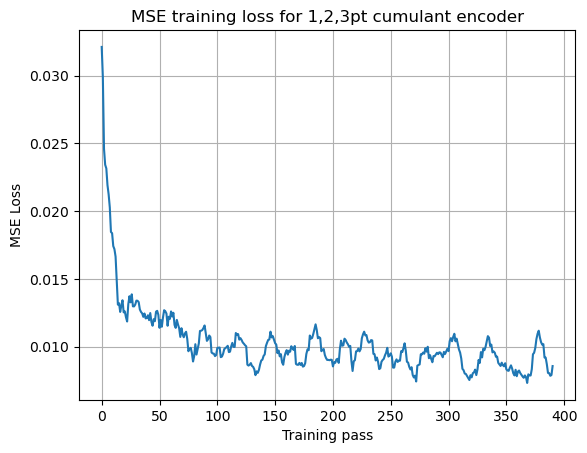

In [18]:
# Step 1: Load the tensor from the saved file
file_path_dec = '/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0.001/loss_hist_all_1pt_0.8-2pt_0.001-3pt_simpleout'  # Replace with the path to your saved tensor file
loaded_tensor_dec = torch.load(file_path_dec)

file_path_enc = '/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0.001/enc_loss_hist'  # Replace with the path to your saved tensor file
loaded_tensor_enc = torch.load(file_path_enc)


# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor_dec.numpy()

# Step 3: Plot the data using Matplotlib



plt.plot(loaded_tensor_dec[5:200])
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1,2,3pt cumulant decoder')
plt.grid(True)
# plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/losses/dec_training_loss_123-1_1_0.015.pdf')
plt.show()

plt.plot(moving_average(loaded_tensor_dec[150:], 10))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('[SEE SCALE] Running average MSE training loss for 1, 2 and 3 point cumulant decoder (passes 150+)')
plt.tight_layout()
plt.grid(True)
plt.show()

plt.plot(moving_average(loaded_tensor_enc[:], 10))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1,2,3pt cumulant encoder')
plt.grid(True)
# plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/losses/dec_training_loss_123-1_1_0.015.pdf')
plt.show()

### Losses (Validation)

In [19]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_321 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(1600, 1900):
    flattened_orig_batch = orig_images_3pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_3pt[train_pass], axis=0)
    mse_321.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_321)/len(mse_321))


tensor(0.6216)


 ## 1pt and 2pt functions

In [20]:
orig_images_2pt = torch.load('/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0/batch_avg_approx_all_1pt_0.8-2pt_0.0-3pt_simpleout')
reconstructions_2pt = torch.load('/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0/mixed_reconstr_avg_approx_all_1pt_0.8-2pt_0.0-3pt_simpleout')
len(reconstructions_2pt)
# stiff_reconstructions = torch.load('/home/as/astapleton_phd/dsb/subtle_diffusion/correlators/correlator_nn/reconstr/stiff_reconstr_avg_approx')

3250

Batch size: 16
Num digits:  16


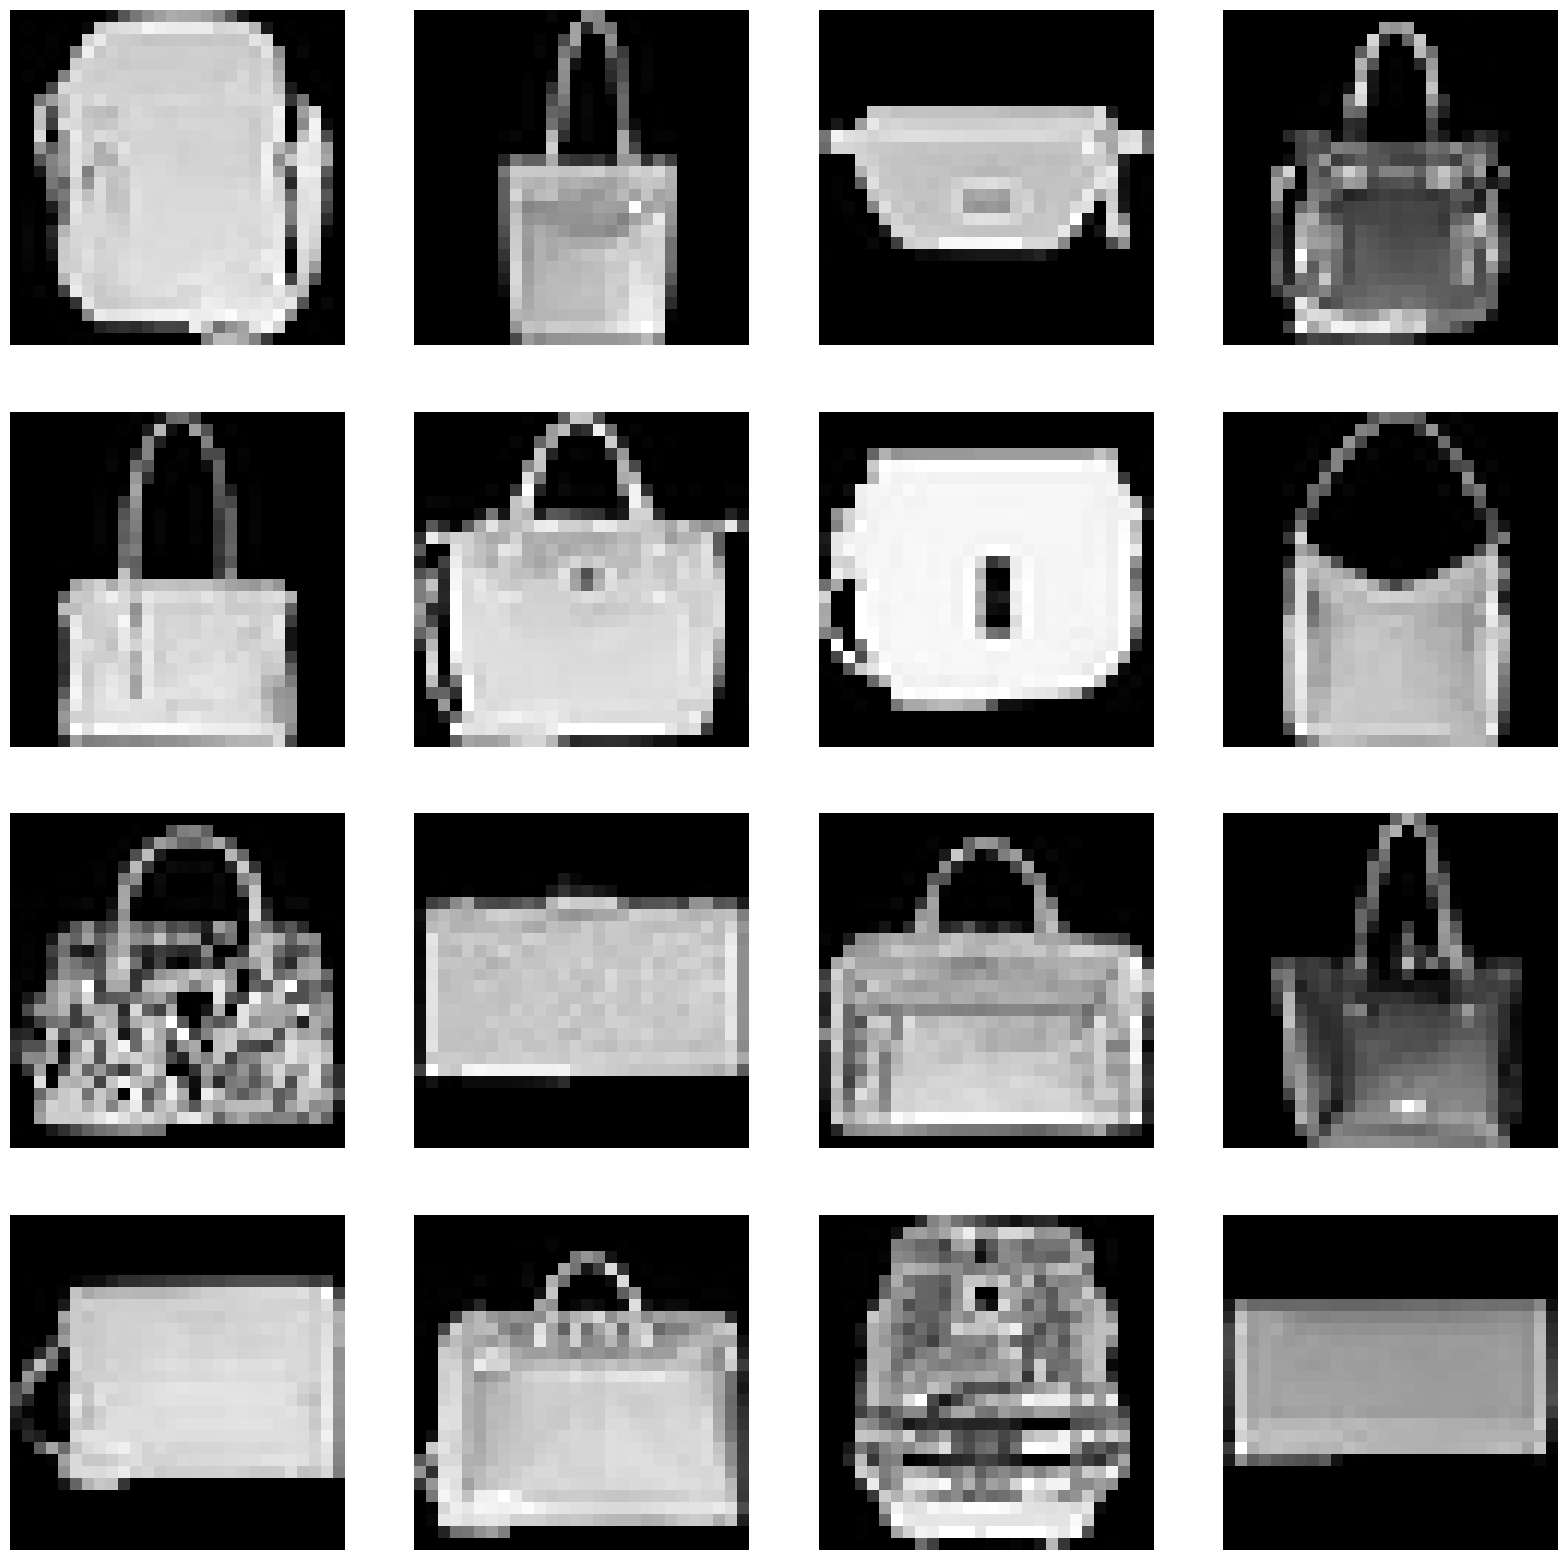

In [21]:
plot_mnist_digits(orig_images_2pt, ki_kf='12', reconstr=False)

In [22]:
new_reconstructions_2pt = []
for batch in reconstructions_2pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_2pt.append(tidied_batch)
# reconstructions_2pt = new_reconstructions_2pt

Batch size: 16
Num digits:  16


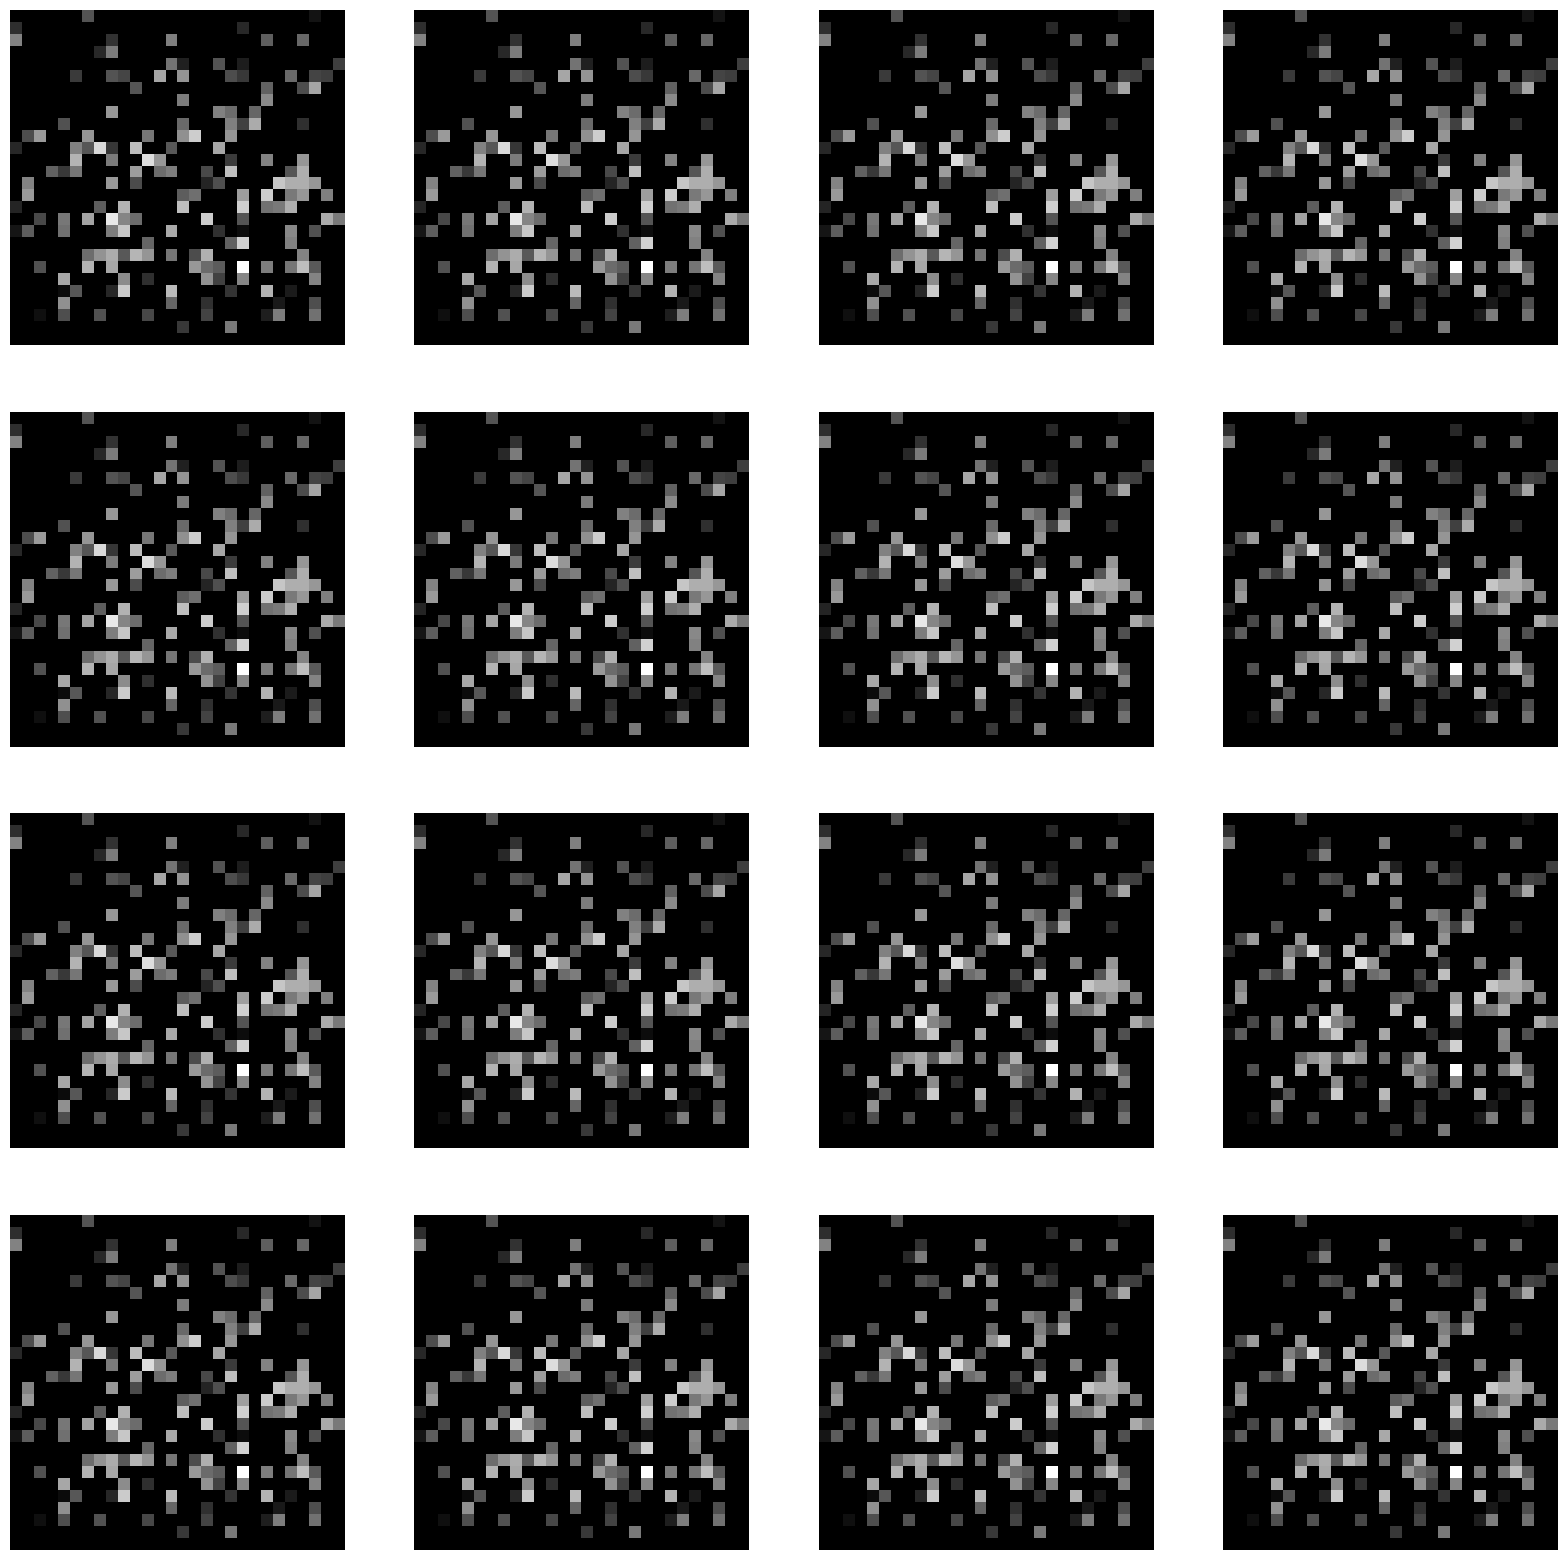

In [23]:
plot_mnist_digits(new_reconstructions_2pt[1900:], ki_kf='12', reconstr=True)

### Losses (Training) - 1&2pt

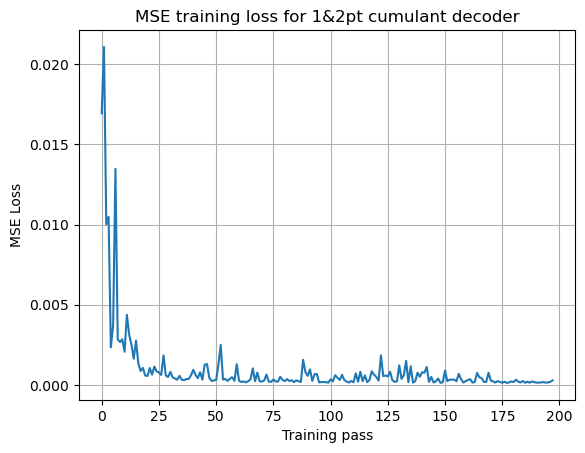

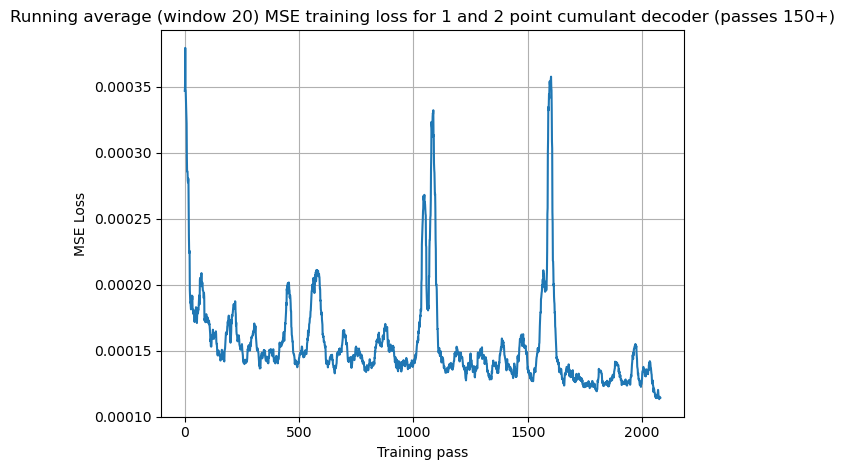

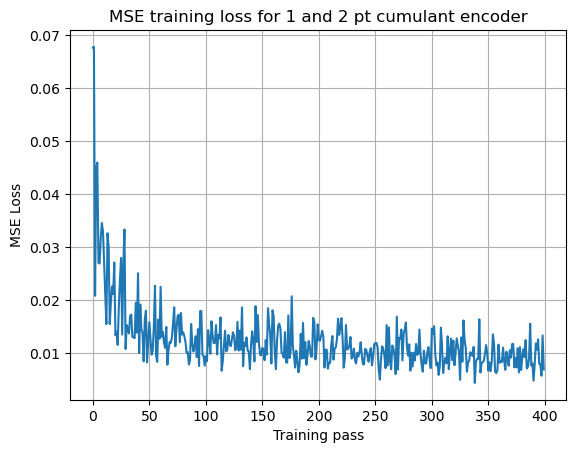

In [24]:
# Step 1: Load the tensor from the saved file
file_path_dec= '/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0/loss_hist_all_1pt_0.8-2pt_0.0-3pt_simpleout'
loaded_tensor_dec = torch.load(file_path_dec)

file_path_enc= '/Users/as/Desktop/reconstructions/moments/FashionMNIST/2pt-0.8_3pt-0/enc_loss_hist' 
loaded_tensor_enc = torch.load(file_path_enc)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor_dec.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(loaded_tensor_dec[2:200])
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1&2pt cumulant decoder')
plt.grid(True)
plt.show()

plt.plot(moving_average(loaded_tensor_dec[150:2250], 20))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('Running average (window 20) MSE training loss for 1 and 2 point cumulant decoder (passes 150+)')
plt.tight_layout()
plt.grid(True)
plt.show()

plt.plot(moving_average(loaded_tensor_enc[:], 1))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1 and 2 pt cumulant encoder')
plt.grid(True)
# plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/losses/dec_training_loss_123-1_1_0.015.pdf')
plt.show()



### Losses (Validation)

In [20]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_21 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(1600, 1900):
    flattened_orig_batch = orig_images_2pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_2pt[train_pass], axis=0)
    mse_21.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_21)/len(mse_21))

tensor(0.2203)


## 1 and 3pt functions

In [21]:
orig_images_13pt = torch.load('/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.001_variable/batch_avg_approx_all_1pt_0.0-2pt_0.001-3pt_simpleout')
reconstructions_13pt = torch.load('/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.001_variable/mixed_reconstr_avg_approx_all_1pt_0.0-2pt_0.001-3pt_simpleout')
len(reconstructions_13pt)

3250

Batch size: 16
Num digits:  16


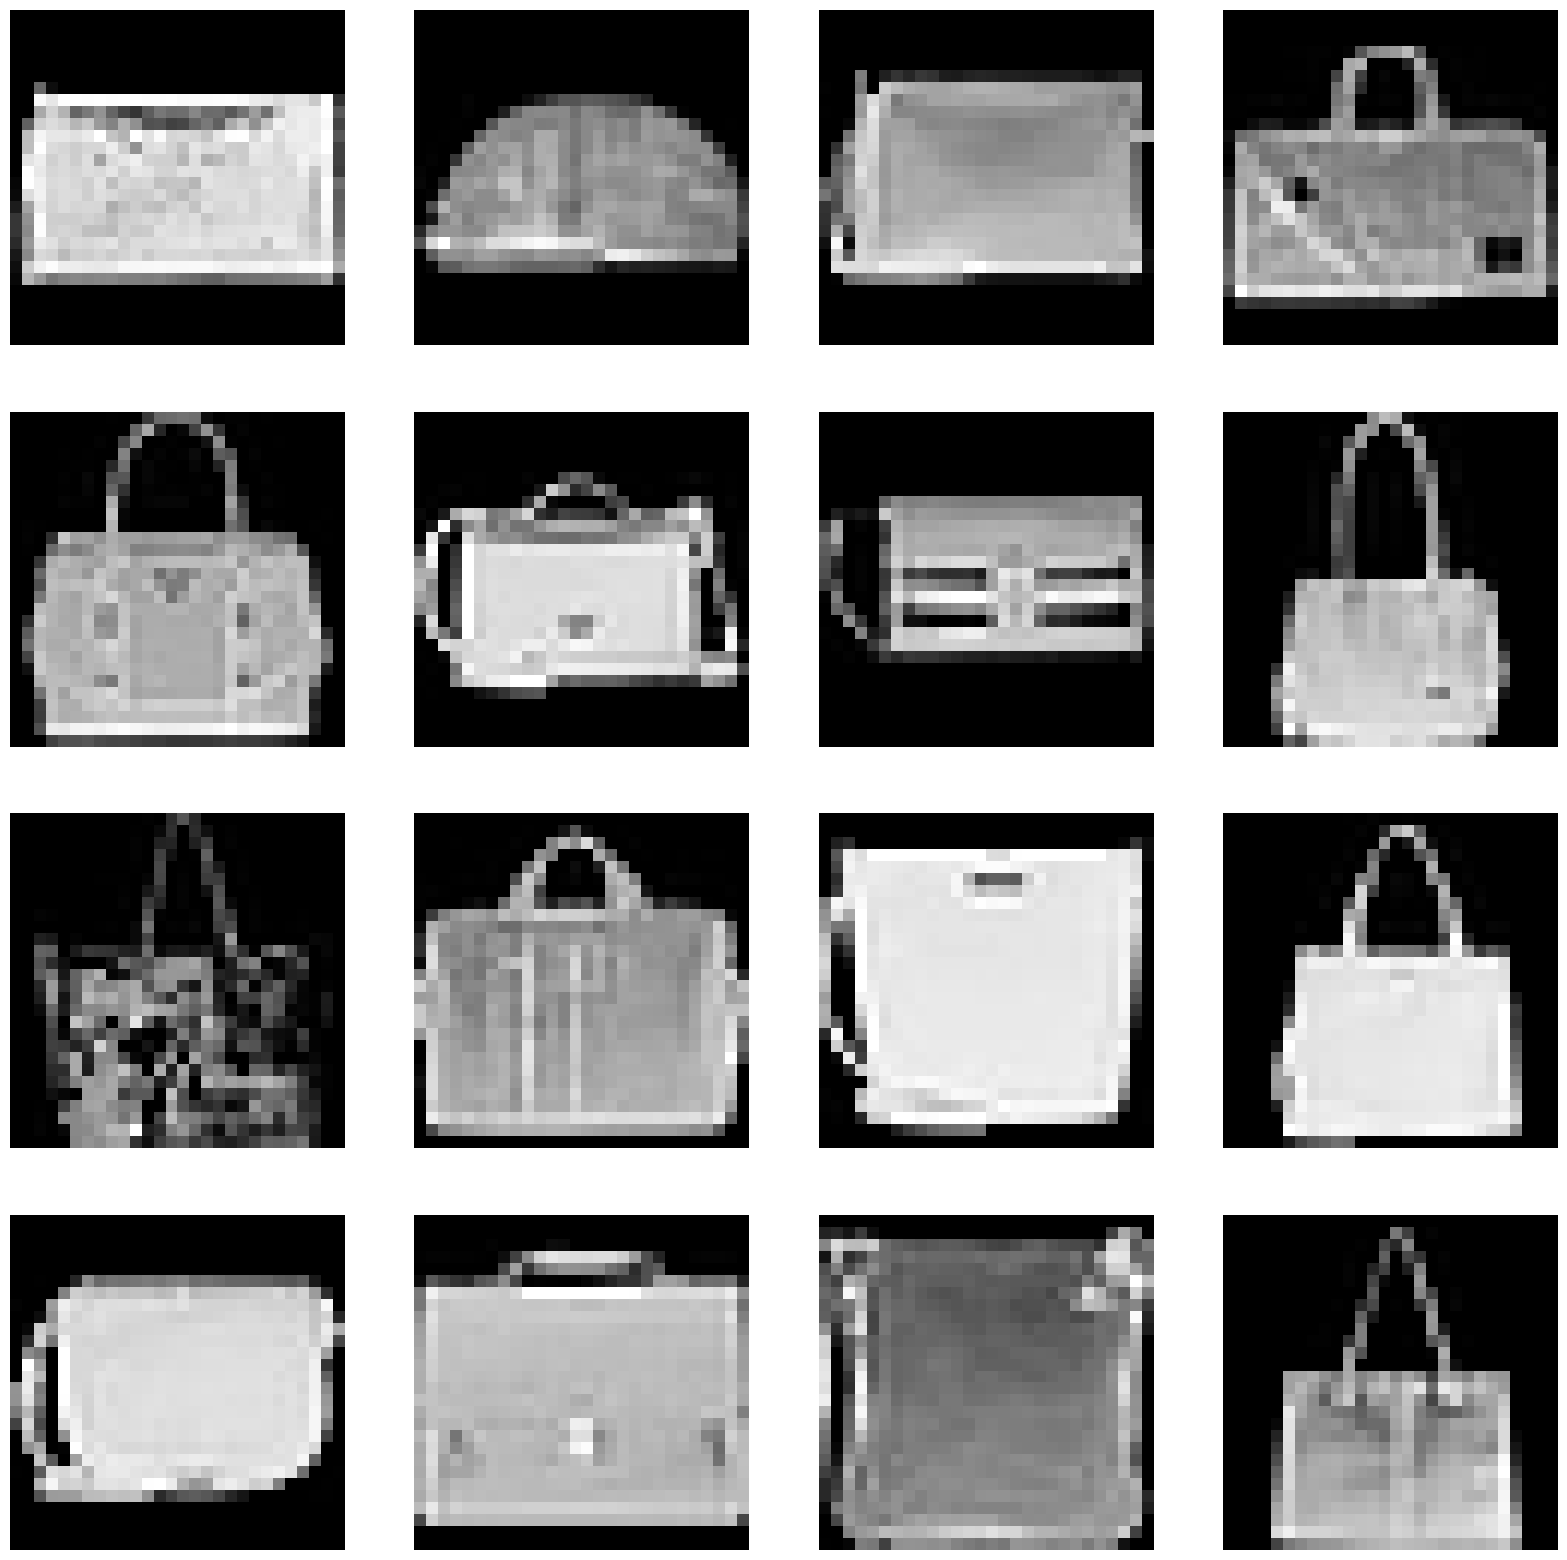

In [22]:
plot_mnist_digits(orig_images_13pt, ki_kf='13', reconstr=False)

In [23]:
new_reconstructions_13pt = []
for batch in reconstructions_13pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_13pt.append(tidied_batch)

Batch size: 16
Num digits:  16


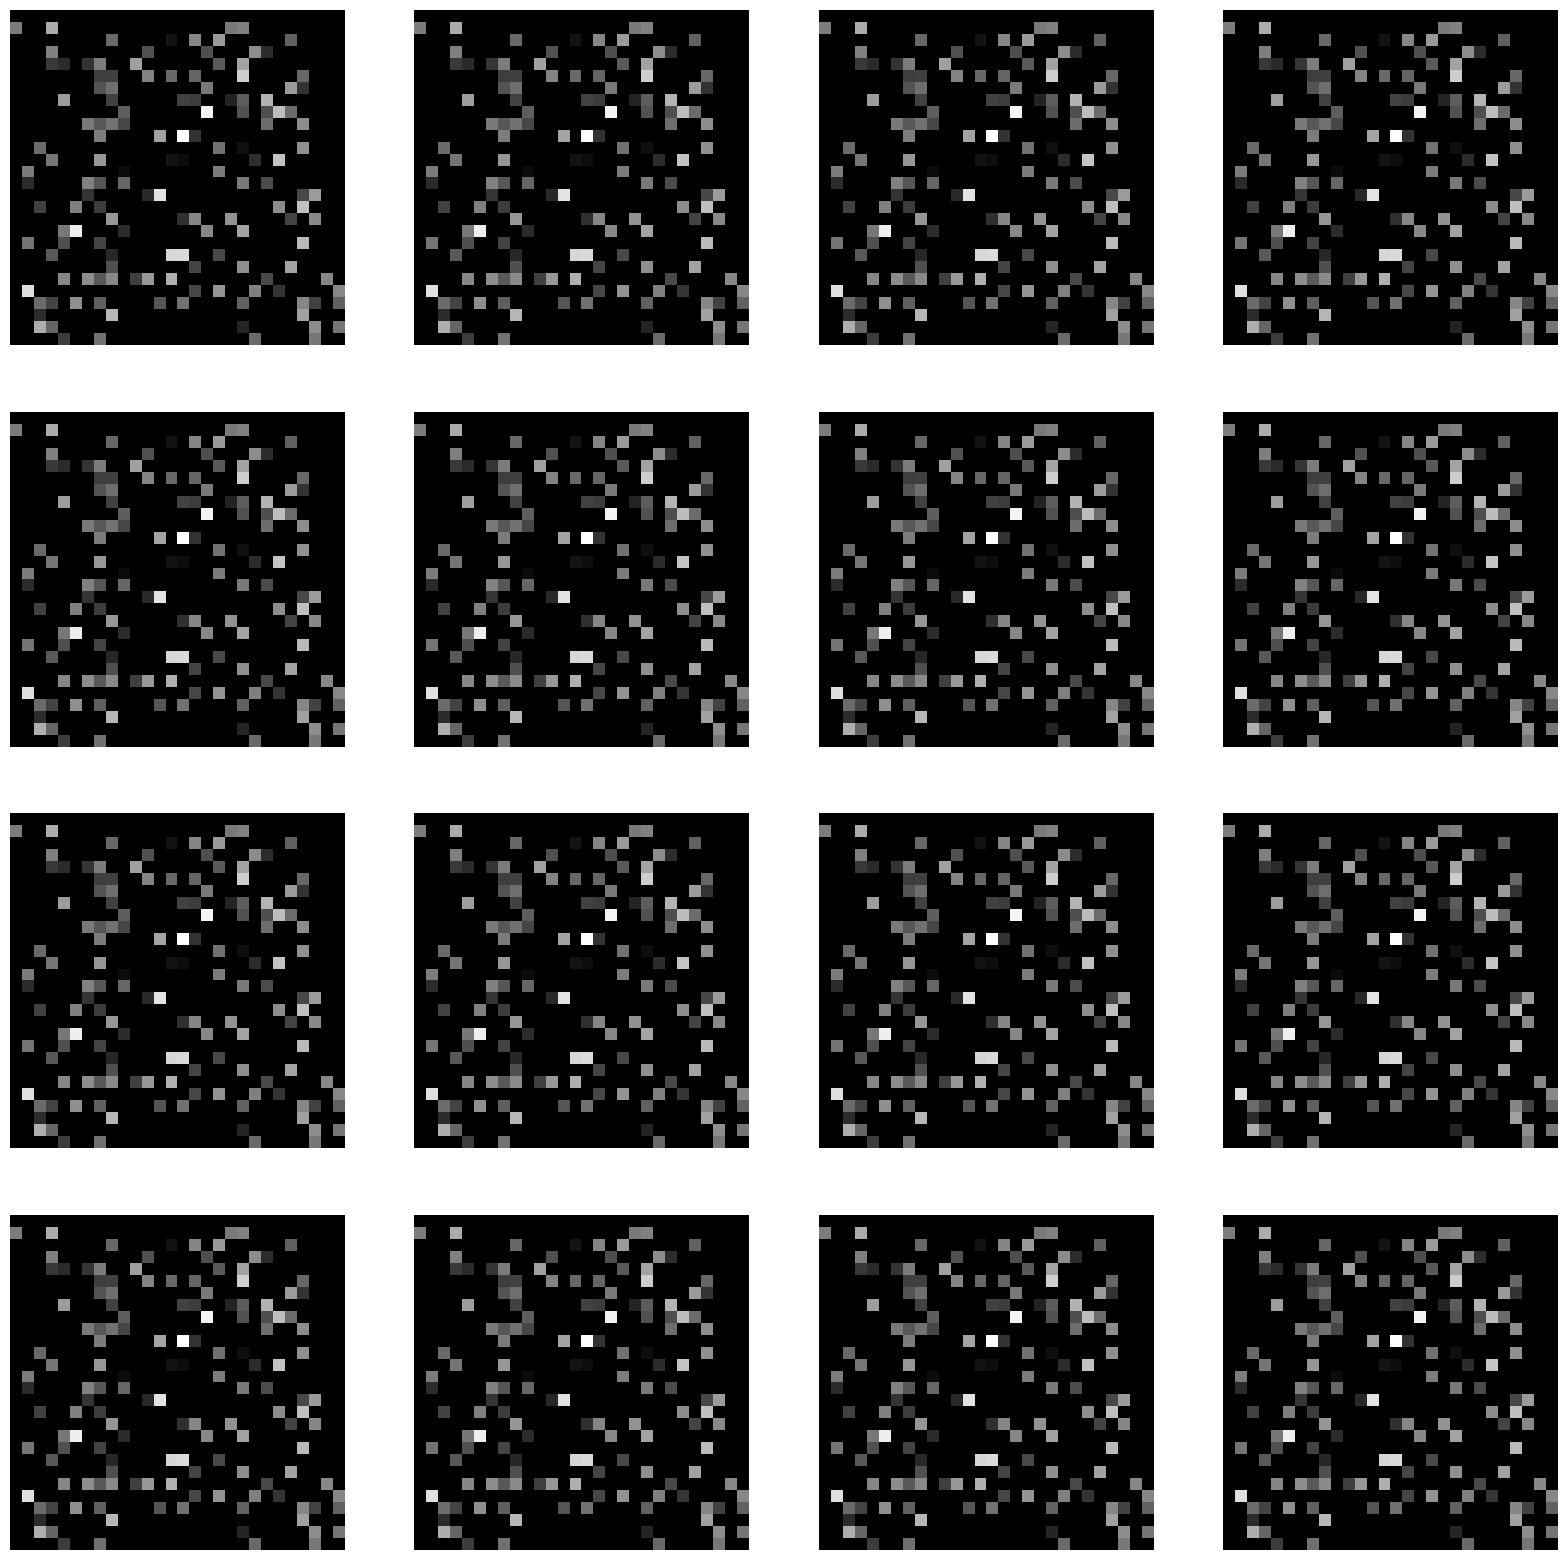

In [24]:
plot_mnist_digits(new_reconstructions_13pt[1900:], ki_kf='13', reconstr=True)

### Losses (Training) 1 and 3 pt

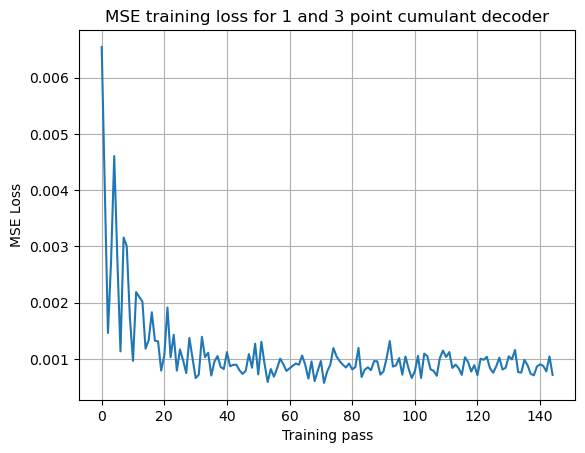

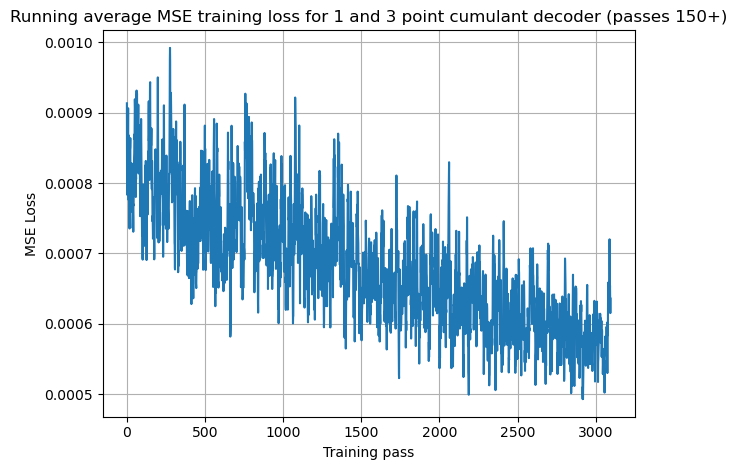

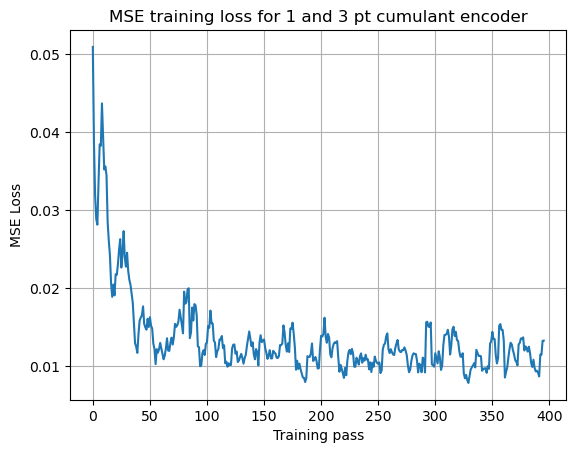

In [25]:
# Step 1: Load the tensor from the saved file
file_path_dec= '/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.001_variable/loss_hist_all_1pt_0.0-2pt_0.001-3pt_simpleout'
loaded_tensor_dec = torch.load(file_path_dec)

file_path_enc= '/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.001_variable/enc_loss_hist' 
loaded_tensor_enc = torch.load(file_path_enc)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor_dec.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(loaded_tensor_dec[5:150])
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1 and 3 point cumulant decoder')
plt.grid(True)
plt.show()

plt.plot(moving_average(loaded_tensor_dec[150:], 5))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('Running average MSE training loss for 1 and 3 point cumulant decoder (passes 150+)')
plt.tight_layout()
plt.grid(True)
plt.show()

plt.plot(moving_average(loaded_tensor_enc[:], 5))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1 and 3 pt cumulant encoder')
plt.grid(True)
# plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/losses/dec_training_loss_123-1_1_0.015.pdf')
plt.show()

### Losses (Validation) -- 1 and 3 point

In [26]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_13 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(1600, 1900):
    flattened_orig_batch = orig_images_13pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_13pt[train_pass], axis=0)
    mse_13.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_13)/len(mse_13))

tensor(0.4733)


## 1pt only

In [27]:
orig_images_1pt = torch.load('/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.0/batch_avg_approx_all_1pt_0.0-2pt_0.0-3pt_simpleout')
reconstructions_1pt = torch.load('/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.0/mixed_reconstr_avg_approx_all_1pt_0.0-2pt_0.0-3pt_simpleout')

Batch size: 16
Num digits:  16


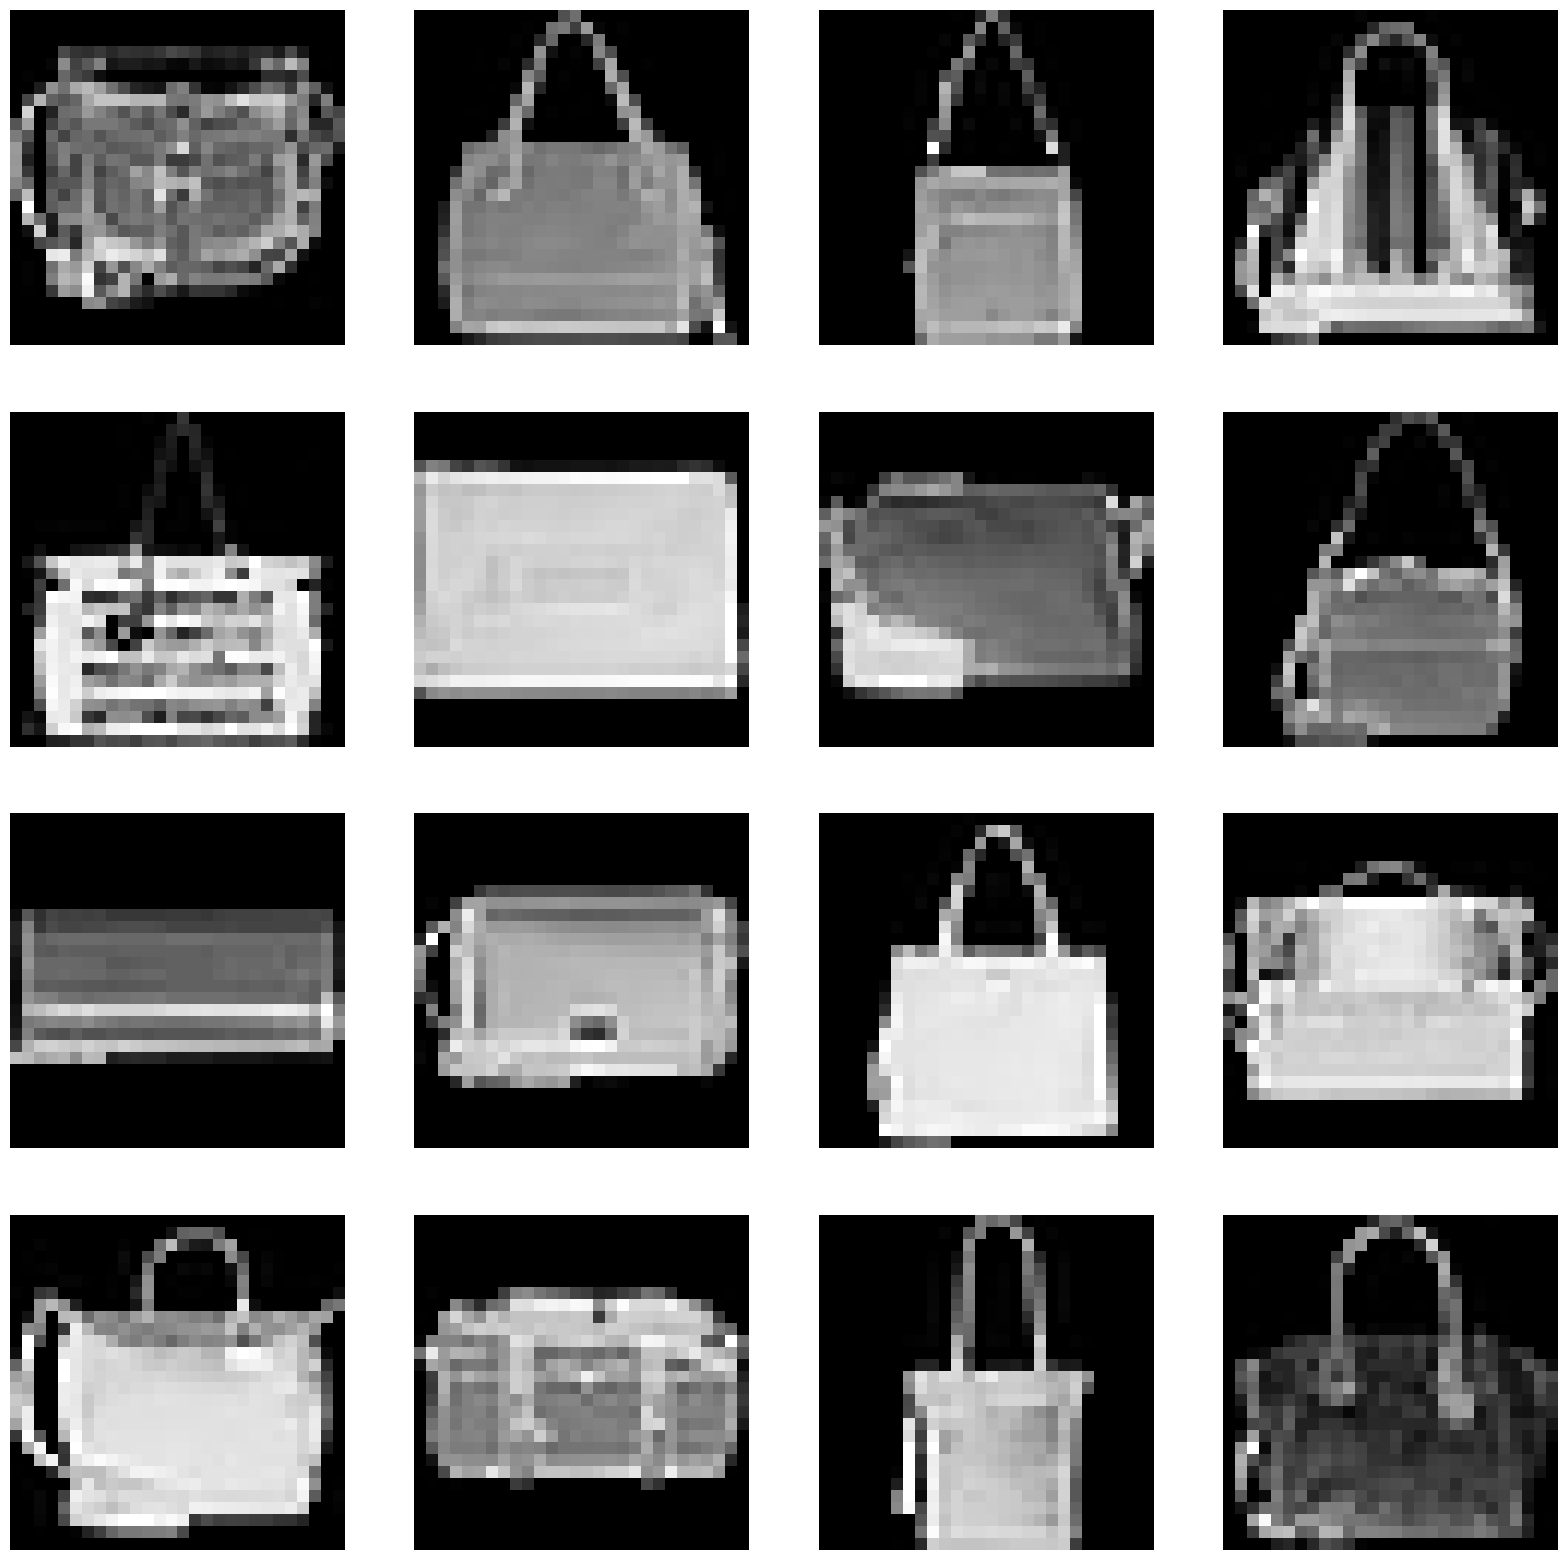

In [28]:
plot_mnist_digits(orig_images_1pt, ki_kf='1', reconstr=False)

In [29]:
new_reconstructions_1pt = []
for batch in reconstructions_1pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_1pt.append(tidied_batch)
# reconstructions_2pt = new_reconstructions_2pt

Batch size: 16
Num digits:  16


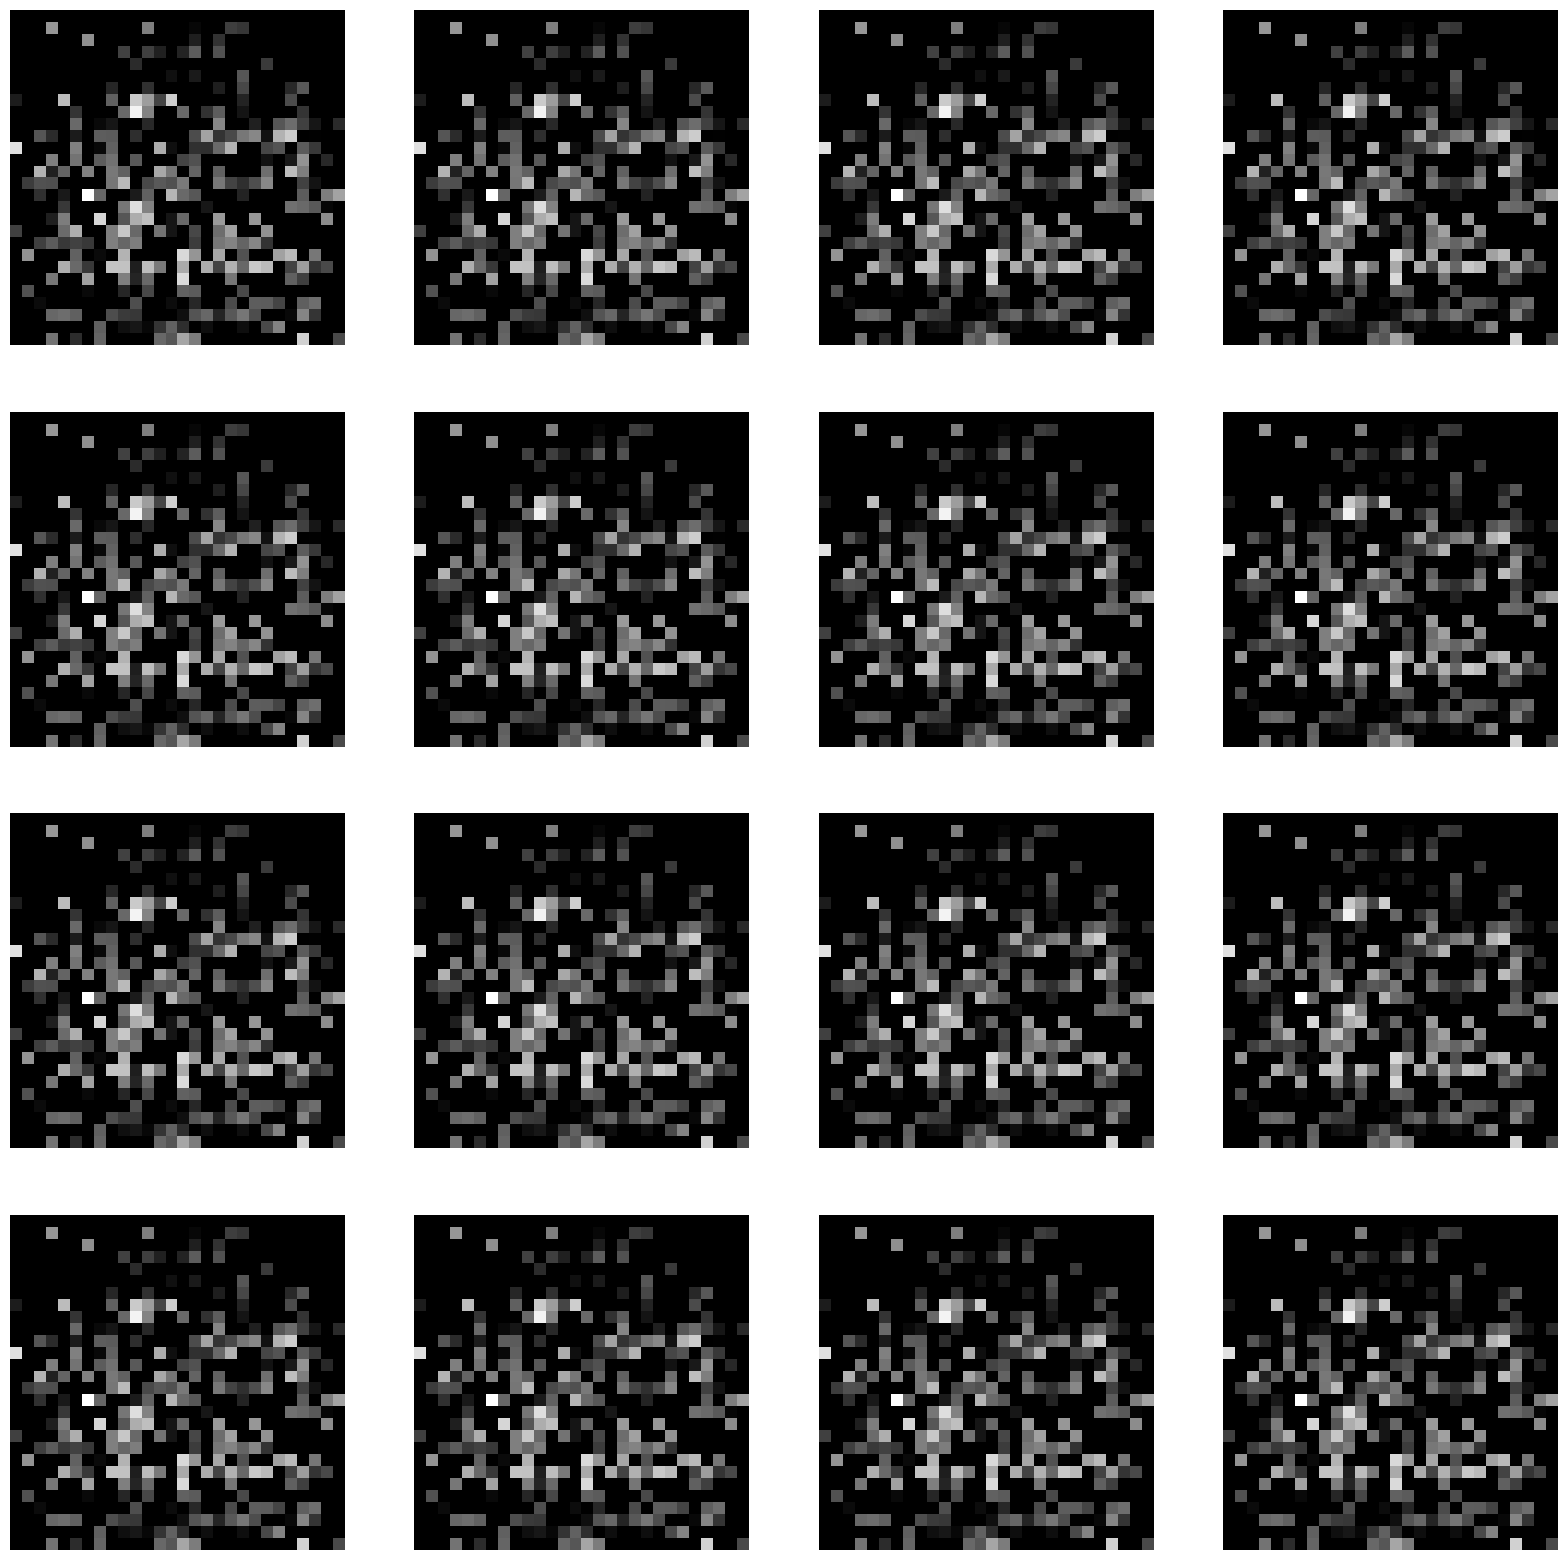

In [30]:
plot_mnist_digits(new_reconstructions_1pt[1900:], ki_kf='1', reconstr=True)

### Losses (Training) -- 1pt Only

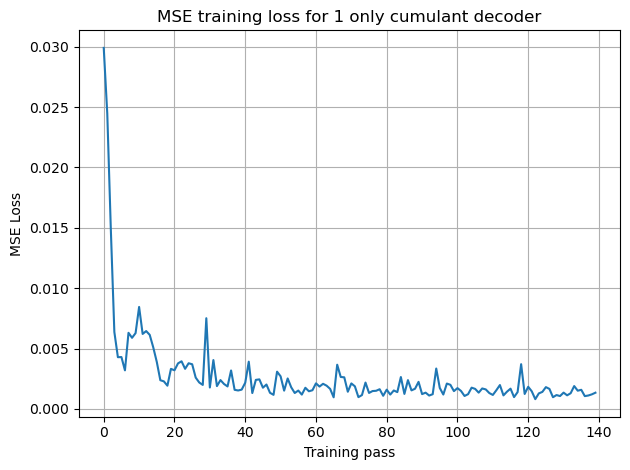

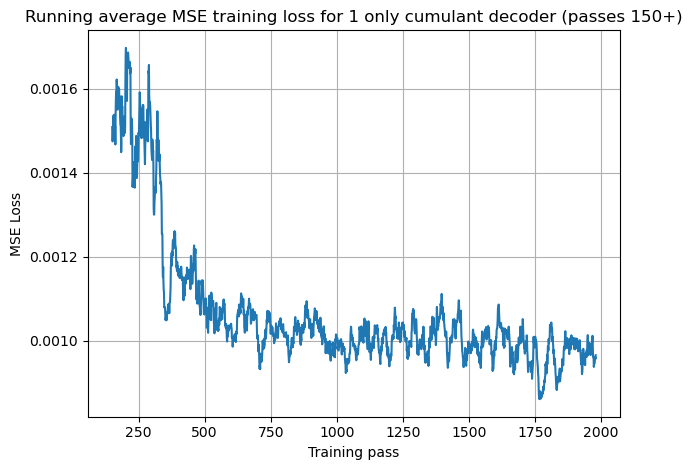

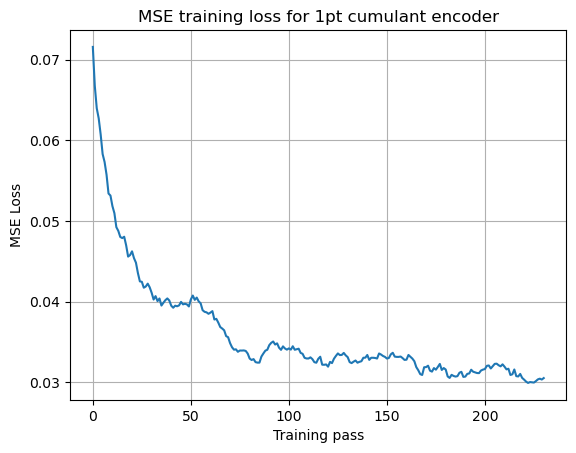

In [31]:
# Step 1: Load the tensor from the saved file
file_path_dec= '/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.0/loss_hist_all_1pt_0.0-2pt_0.0-3pt_simpleout'  # Replace with the path to your saved tensor file
loaded_tensor_dec = torch.load(file_path_dec)

file_path_enc= '/Users/as/Desktop/reconstructions/FashionMNIST/bs16/lr_0.0001/larger_init_batch/2pt-0.0_3pt-0.0/enc_loss_hist' 
loaded_tensor_enc = torch.load(file_path_enc)
# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor_dec.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(loaded_tensor_dec[10:150])
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1 only cumulant decoder')
plt.grid(True)
plt.tight_layout()
# plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/losses/dec_training_loss_123-1_0_0.0.pdf')
plt.show()

x = np.arange(len(moving_average(loaded_tensor_dec[150:], 20))) + 150
plt.plot(x, moving_average(loaded_tensor_dec[150:], 20))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('Running average MSE training loss for 1 only cumulant decoder (passes 150+)')
plt.tight_layout()
plt.grid(True)
plt.show()

plt.plot(moving_average(loaded_tensor_enc[:], 20))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
plt.title('MSE training loss for 1pt cumulant encoder')
plt.grid(True)
# plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/losses/dec_training_loss_123-1_1_0.015.pdf')
plt.show()


### Losses (Validation)

In [32]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_1 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(1600, 1900):
    flattened_orig_batch = orig_images_1pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_1pt[train_pass], axis=0)
    mse_1.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_1)/len(mse_1))

tensor(0.3669)


### Combined MSE losses (val)

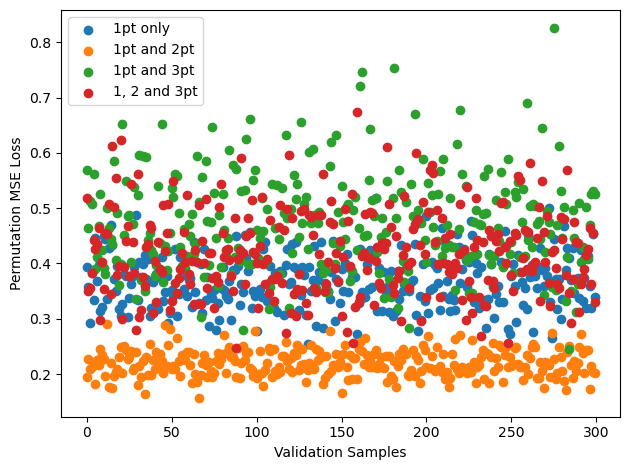

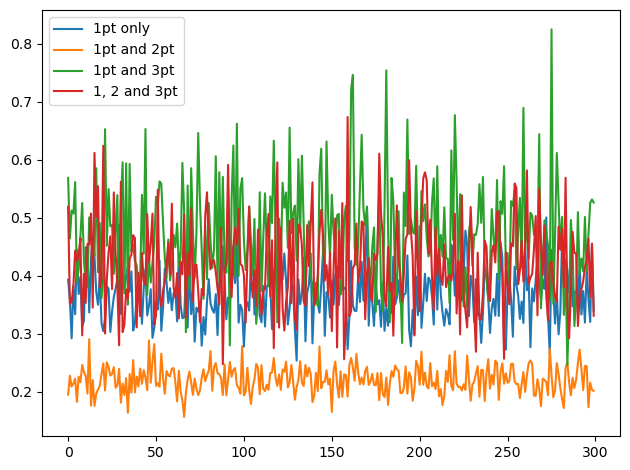

In [33]:
# Combined MSE validation
grainer = 1

plt.scatter(range(len(moving_average(mse_1, grainer))), moving_average(mse_1, grainer), label='1pt only')
plt.scatter(range(len(moving_average(mse_21, grainer))), moving_average(mse_21, grainer), label='1pt and 2pt')
plt.scatter(range(len(moving_average(mse_13, grainer))), moving_average(mse_13, grainer), label='1pt and 3pt')
plt.scatter(range(len(moving_average(mse_321, grainer))), moving_average(mse_321, grainer), label='1, 2 and 3pt')
plt.legend()
plt.ylabel('Permutation MSE Loss')
plt.xlabel('Validation Samples')
plt.tight_layout()
plt.show()


plt.plot(range(len(moving_average(mse_1, grainer))), moving_average(mse_1, grainer), label='1pt only')
plt.plot(range(len(moving_average(mse_21, grainer))), moving_average(mse_21, grainer), label='1pt and 2pt')
plt.plot(range(len(moving_average(mse_13, grainer))), moving_average(mse_13, grainer), label='1pt and 3pt')
plt.plot(range(len(moving_average(mse_321, grainer))), moving_average(mse_321, grainer), label='1, 2 and 3pt')
plt.legend()
plt.tight_layout()
plt.show()